In [292]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

In [293]:
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms

In [294]:
!nvidia-smi

Fri Apr 15 21:07:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
| 41%   47C    P0    44W / 180W |   1054MiB /  8192MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [295]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [296]:
train_data = pickle.load(open('clean_dataset_2022/train_set.bin', 'rb'))

test_data = pickle.load(open('clean_dataset_2022/test_set.bin', 'rb'))

## SARIMAX

In [297]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Resample

In [298]:
province = ['BKK','CNX','KKC','RAY','SARA','SURAT']

In [299]:
for p in province:
    train_data[p] = train_data[p].resample('6H').mean()

    tmp_df = test_data[p].copy()
    tmp_df['PM25'] = test_data[p]['PM25'].asfreq(freq='6H')
    test_data[p] = test_data[p].resample('6H').mean()
    test_data[p]['PM25'] = tmp_df['PM25']

### Split 70% 30%

In [300]:
train_set = {} ; valid_set = {} ; test_set = test_data

ratio = 0.7

for p in province:
    train_size, valid_size = int(ratio*train_data[p].shape[0]), int((1-ratio)*train_data[p].shape[0])
    train_set[p], valid_set[p] = train_data[p].iloc[:train_size], train_data[p].iloc[train_size: ]

In [301]:
train_set['CNX']['PM25']

Time
2017-07-01 00:00:00    12.000000
2017-07-01 06:00:00    14.333333
2017-07-01 12:00:00    12.500000
2017-07-01 18:00:00    16.666667
2017-07-02 00:00:00    14.833333
                         ...    
2019-08-05 18:00:00    11.333333
2019-08-06 00:00:00     9.166667
2019-08-06 06:00:00    13.333333
2019-08-06 12:00:00    13.833333
2019-08-06 18:00:00    15.333333
Freq: 6H, Name: PM25, Length: 3068, dtype: float64

### Training 6 provinces with *minimal_SARIMAX*

##### Tuning Parameters

In [302]:
order = np.array([(2, 0, 0), (2, 1, 0), (2, 1, 0), (2, 1, 0), (1, 0, 1), (2, 0, 0)])
seasonal_order = np.array([(1, 0, 0, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 0, 0, 1461), (0, 0, 0, 1461), (0, 1, 0, 1461)])

exog_order = {}
exog_order['Temp'] = np.array([(1, 1, 0), (1, 1, 0), (1, 1, 0), (1, 0, 0), (1, 1, 0), (1, 1, 0)])
exog_order['WindSpeed'] = np.array([(1, 1, 0), (1, 1, 0), (1, 1, 0), (1, 1, 0), (1, 0, 0), (1, 1, 0)])
exog_order['WindDir'] = np.array([(1, 1, 0), (1, 0, 0), (2, 0, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1)])

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = np.array([(0, 1, 1, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 0, 1, 1461), (0, 1, 0, 1461), (0, 1, 1, 1461)])
exog_seasonal_order['WindSpeed'] = np.array([(0, 1, 1, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 0, 0, 1461), (0, 1, 1, 1461)])
exog_seasonal_order['WindDir'] = np.array([(1, 1, 0, 1461), (0, 1, 0, 1461), (1, 0, 0, 1461), (1, 1, 0, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461)])

exog_columns = ['Temp', 'WindSpeed', 'WindDir']

In [303]:
def getPDQ(data, pred, idx, order=(0, 0, 0), ss_order=(0, 0, 0, 1461)):
    x = []
    
    for p_i in range(order[0]):
        p_idx = idx-p_i-1
        if (p_idx<0): x.append(0)
        else: x.append(data[p_idx])
    
    for d_i in range(order[1]):
        d_idx = idx-d_i-2
        if (d_idx<0): x.append(0)
        else: x.append(data[d_idx+1] - data[d_idx])
    
    for q_i in range(order[2]):
        q_idx = idx-q_i-1
        if (q_idx<0): x.append(0)
        else: x.append(data[q_idx] - pred[q_idx])
    
    for P_i in range(1, ss_order[0]):
        P_idx = idx-P_i*ss_order[3]
        if (P_idx<0): x.append(0)
        else: x.append(data[P_idx])
    
    for D_i in range(1, ss_order[1]):
        D_idx = idx-2*D_i*ss_order[3]
        if (D_idx<0): x.append(0)
        else: x.append(data[D_idx+1*ss_order[3]] - data[D_idx])
    
    for Q_i in range(1, ss_order[2]):
        Q_idx = idx-Q_i*ss_order[3]
        if (Q_idx<0): x.append(0)
        else: x.append(data[Q_idx] - pred[Q_idx])
    
    return torch.Tensor(x)

In [304]:
from torch.autograd import Variable
from tqdm import tqdm

class LinearRegression(nn.Module):
    def __init__(self, order, ss_order):
        super(LinearRegression, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(order.sum(), 1),
            nn.LeakyReLU(0.2)
        )
        self.mainSS = nn.Sequential(
            nn.Linear(ss_order[:3].sum(), 1),
            nn.LeakyReLU(0.2)
        )
        self.order = order
        self.ss_order = ss_order
        self.optim = None
        self.predictions = None
        self.twelve = None
        self.losses = []

    def forward(self, x, xSS=None):
        if xSS is None:
            return self.main(x)
        return self.main(x) + self.mainSS(xSS)

    def initSaveDataFrame(self, start_time, trainX):
        
        #sav_df
        sav_df = pd.DataFrame(columns=['Time','Predict','Actual'])
        sav_init_item = {'Time': start_time, 'Predict': 0, 'Actual': trainX[0].item()}
        sav_df = sav_df.append(sav_init_item, ignore_index=True, sort=False)
        
        self.predictions = sav_df
        
        #twelve_df
        twelve_df = pd.DataFrame(columns=['Time','Predict'])
        twelve_init_item = {'Time': start_time, 'Predict': 0}
        twelve_df = twelve_df.append(twelve_init_item, ignore_index=True)
        
        self.twelve = twelve_df
    
    def savePrediction(self, time, predict, actual):
        sav_item = {'Time': time, 'Predict': predict, 'Actual': actual}
        self.predictions = self.predictions.append(sav_item, ignore_index=True, sort=False)
    
    def saveTwelve(self, time, predict):
        sav_item = {'Time': time, 'Predict': predict}
        self.twelve = self.twelve.append(sav_item, ignore_index=True)
    
    def fit(self, train_data, N_ITER=100, step=1):
        
        self.train()
        
        trainX = torch.Tensor(train_data.values.flatten()).to(device)
        criterion = torch.nn.MSELoss()
        
        #learn in N_ITER loops
        for i in tqdm(range(N_ITER)):
#         for i in range(N_ITER):
            
#             self.optim.param_groups[0]['lr'] *= 0.5
            
            start_time = train_data.index[0]
            save_time = start_time
            
            #initSaveDataFrame
            self.initSaveDataFrame(start_time=start_time, trainX=trainX)

#             for t in tqdm(range(1, trainX.shape[0])):
            for t in range(1, trainX.shape[0]):
#                 self.optim.param_groups[0]['lr'] *= 0.99895
                save_time += pd.Timedelta(hours=6) 
                
                #running_in_steps
                for s in range(step):
                    if(t+s>=trainX.shape[0]): break
                    input_x = getPDQ(trainX, self.predictions['Predict'], t+s, self.order, self.ss_order).to(device)
                    y_pred = self(input_x)
                    current_time = save_time+s*pd.Timedelta(hours=6)
                    self.savePrediction(current_time, y_pred.item(), trainX[t+s].item())
                    self.saveTwelve(current_time, y_pred.item())
                  
                #update_parameters
                if (t > step+1):
                    tmp = self.twelve[self.twelve['Time']==save_time-pd.Timedelta(hours=6)]
                    tmp_pred = np.array(tmp['Predict'].values, dtype=np.float32)
                    
                    tmp_pred = torch.Tensor(tmp_pred).to(device).requires_grad_(True)      
                    labels = trainX[t-1].repeat(tmp_pred.shape[0]).to(device).requires_grad_(False) 
                    
                    loss = criterion(tmp_pred, labels)
                    loss.backward()
                    self.optim.step
                    self.optim.zero_grad()
                    
                    # del 'this time' rows
                    self.twelve = self.twelve[self.twelve['Time']!=save_time-pd.Timedelta(hours=6)]
                
                predictions_tmp = self.predictions
            
            self.losses.append(((np.array(predictions_tmp['Actual'] - predictions_tmp['Predict'])**2).mean())**(1/2))

In [305]:
import torch.optim as optim

model = {}
model_exog = {}

for i, p in enumerate(province):
    model[p] = LinearRegression(order[i], seasonal_order[i])
    model[p] = model[p].to(device)
    model[p].optim =  optim.Adam(model[p].parameters(), lr=0.001, betas=(0.9,0.99))
    
    model_exog[p] = {}
    for exog in exog_columns:
        model_exog[p][exog] = LinearRegression(exog_order[exog][i], exog_seasonal_order[exog][i])
        model_exog[p][exog] = model_exog[p][exog].to(device)
        model_exog[p][exog].optim = optim.Adam(model_exog[p][exog].parameters(), lr=0.001, betas=(0.9,0.99))

In [306]:
# from torchinfo import summary
# summary(model['CNX'], input_size=[(3,),(2,)])

In [307]:
# for p in province:
#     model[p].fit(lr=1e-5, lr_decay=0.999 ,verbose=0)

In [308]:
# for p in province:
#     for exog in exog_columns:
#         if exog == 'WindDir':
#             model_exog[p][exog].fit(lr=5e-7, lr_decay=0.999, verbose=0)
#         else:
#             model_exog[p][exog].fit(lr=1e-5, lr_decay=0.999, verbose=0)

In [309]:
# p, exog, i = ('CNX', 'Temp', 1)

In [310]:
# model_exog[p][exog] = model_exog[p][exog].cuda()

In [ ]:
p, exog, i = ('CNX', 'Temp', 1)

trainX = train_data[p][[exog]]

model_exog[p][exog].fit(trainX, N_ITER=10, step=1)

 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:54<00:49, 16.64s/it]

In [ ]:
# model_exog[p][exog].predictions
# (np.array(model_exog[p][exog].losses).mean())**(1/2)
# len(predictions)

In [ ]:
for name, param in model_exog[p][exog].named_parameters():
    if param.requires_grad:
        print (name, param.data)

In [290]:
model_exog[p][exog].predictions

,Time,Predict,Actual
0,2017-07-01 00:00:00,0,22.900000
1,2017-07-01 06:00:00,-2.517382,25.633333
2,2017-07-01 12:00:00,-2.48494,30.583334
3,2017-07-01 18:00:00,-2.76582,26.200001
4,2017-07-02 00:00:00,-3.43291,23.066668
...,...,...,...
4379,2020-06-29 18:00:00,-2.735196,27.383333
4380,2020-06-30 00:00:00,-3.60939,23.716667
4381,2020-06-30 06:00:00,-3.064767,25.816668
4382,2020-06-30 12:00:00,-2.584239,31.650000


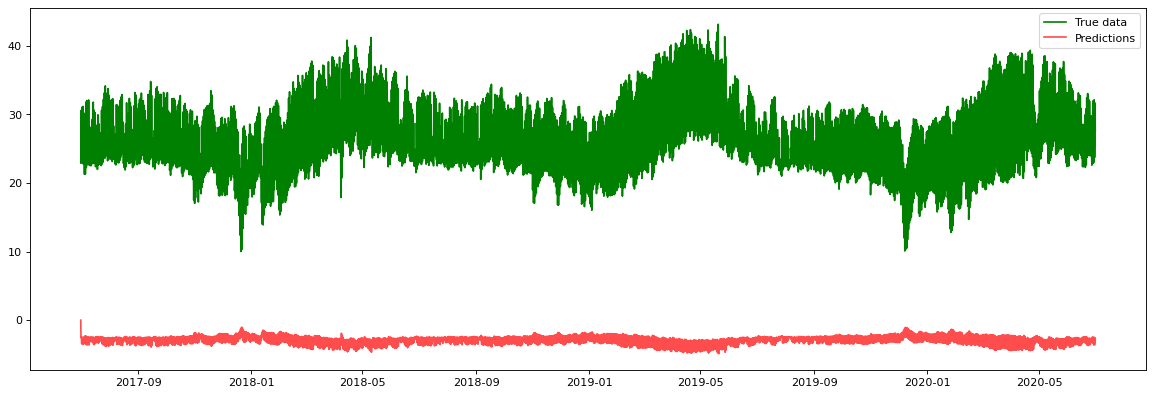

In [291]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(model_exog[p][exog].predictions['Time'], model_exog[p][exog].predictions['Actual'], color='g', label='True data')
plt.plot(model_exog[p][exog].predictions['Time'], model_exog[p][exog].predictions['Predict'], alpha=.7, color='r', label='Predictions')
plt.legend(loc="upper right")
plt.show()

In [140]:
a = np.array(model_exog[p][exog].predictions['Actual'] - model_exog[p][exog].predictions['Predict'])

In [141]:
(a**2).mean()**(1/2)

25.07977088027181

In [113]:
# plt.plot(np.arange(0,1), model_exog[p][exog].losses)
# plt.show()

In [17]:
Result = {}
train_pred_sav = {}
test_pred_sav = {}
Error_save = {}

#### Bangkok

In [14]:
Result['BKK'] = model['BKK'].predict_step(train_data['BKK'][['PM25']],
                                    test_data['BKK'][['PM25']], 
                                    val_X_exog=train_data['BKK'][exog_columns],
                                    y_exog=test_data['BKK'][exog_columns], 
                                    model_exog=model_exog['BKK'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['BKK'], test_pred_sav['BKK'], Error_save['BKK'] = Result['BKK']

100%|██████████| 5847/5847 [15:41<00:00,  6.21it/s]


In [17]:
with open('model_save/model_bkk.model',"wb") as f:
    pickle.dump(model['BKK'], f)

In [15]:
predict = test_pred_sav['BKK'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['BKK'], test_pred_sav['BKK']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

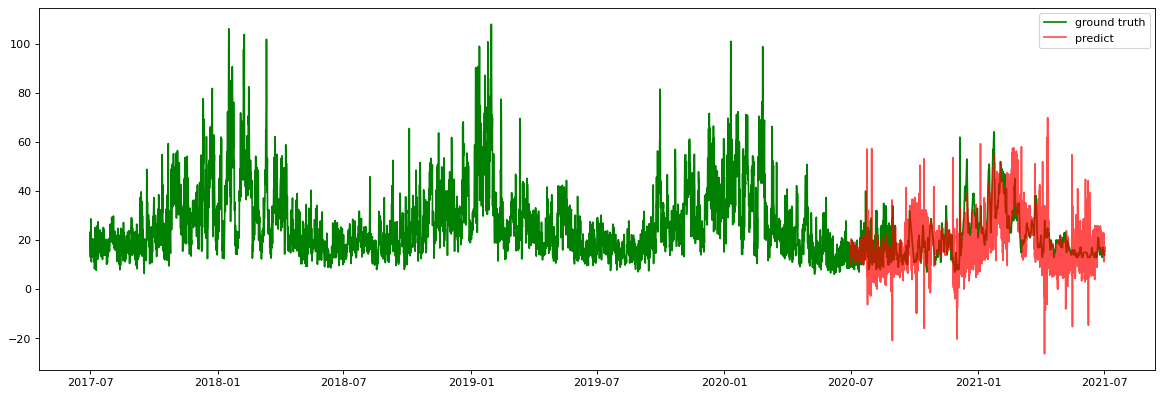

In [16]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [18]:
test_pred_sav['BKK'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_BKK.csv')

#### Chiangmai

In [19]:
Result['CNX'] = model['CNX'].predict_step(train_data['CNX'][['PM25']],
                                    test_data['CNX'][['PM25']], 
                                    val_X_exog=train_data['CNX'][exog_columns],
                                    y_exog=test_data['CNX'][exog_columns], 
                                    model_exog=model_exog['CNX'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['CNX'], test_pred_sav['CNX'], Error_save['CNX'] = Result['CNX']

100%|██████████| 5847/5847 [15:49<00:00,  6.16it/s]


In [20]:
with open('model_save/model_cnx.model',"wb") as f:
    pickle.dump(model['CNX'], f)

In [21]:
predict = test_pred_sav['CNX'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['CNX'],test_pred_sav['CNX']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

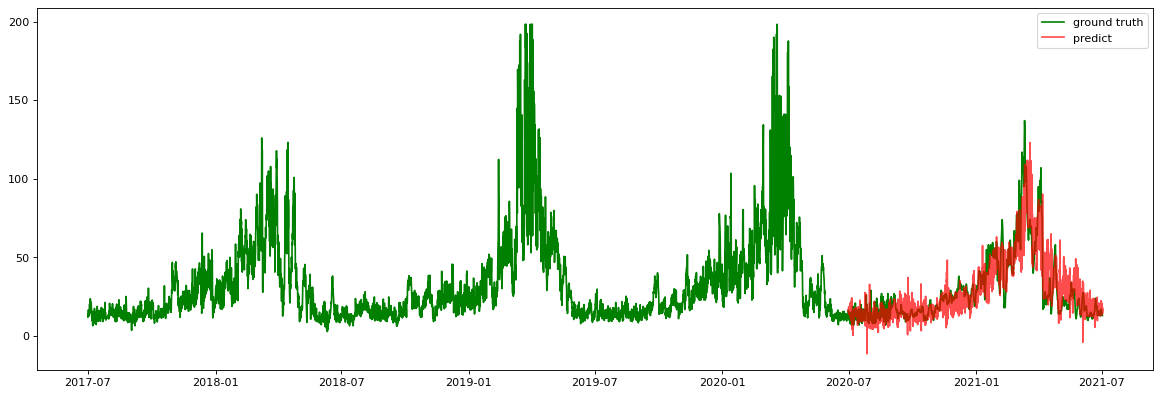

In [22]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [23]:
test_pred_sav['CNX'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_CNX.csv')

#### Khonkaen

In [24]:
Result['KKC'] = model['KKC'].predict_step(train_data['KKC'][['PM25']],
                                    test_data['KKC'][['PM25']], 
                                    val_X_exog=train_data['KKC'][exog_columns],
                                    y_exog=test_data['KKC'][exog_columns], 
                                    model_exog=model_exog['KKC'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['KKC'], test_pred_sav['KKC'], Error_save['KKC'] = Result['KKC']

100%|██████████| 5847/5847 [16:36<00:00,  5.87it/s]


In [25]:
with open('model_save/model_kkc.model',"wb") as f:
    pickle.dump(model['KKC'], f)

In [26]:
predict = test_pred_sav['KKC'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['KKC'],test_pred_sav['KKC']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

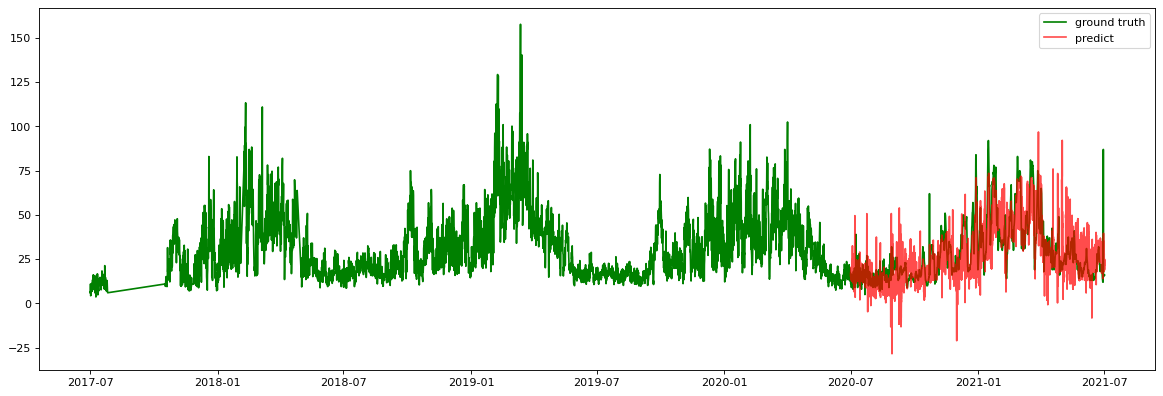

In [31]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [28]:
test_pred_sav['KKC'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_KKC.csv')

#### Rayong

In [29]:
Result['RAY'] = model['RAY'].predict_step(train_data['RAY'][['PM25']],
                                    test_data['RAY'][['PM25']], 
                                    val_X_exog=train_data['RAY'][exog_columns],
                                    y_exog=test_data['RAY'][exog_columns], 
                                    model_exog=model_exog['RAY'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['RAY'], test_pred_sav['RAY'], Error_save['RAY'] = Result['RAY']

100%|██████████| 5847/5847 [16:56<00:00,  5.75it/s]


In [32]:
with open('model_save/model_ray.model',"wb") as f:
    pickle.dump(model['RAY'], f)

In [35]:
predict = test_pred_sav['RAY'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['RAY'],test_pred_sav['RAY']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

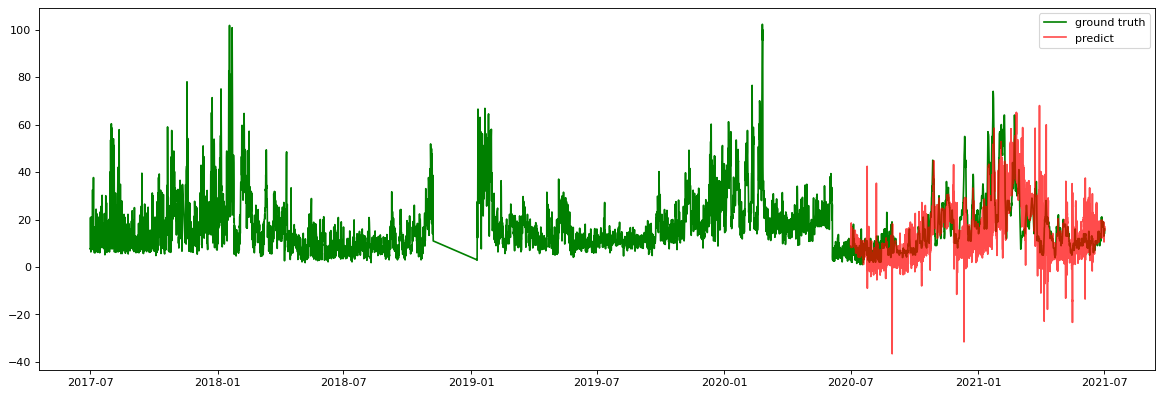

In [36]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [37]:
test_pred_sav['RAY'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_RAY.csv')

#### Saraburi

In [25]:
Result['SARA'] = model['SARA'].predict_step(train_data['SARA'][['PM25']],
                                    test_data['SARA'][['PM25']], 
                                    val_X_exog=train_data['SARA'][exog_columns],
                                    y_exog=test_data['SARA'][exog_columns], 
                                    model_exog=model_exog['SARA'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['SARA'], test_pred_sav['SARA'], Error_save['SARA'] = Result['SARA']

100%|██████████| 5847/5847 [15:19<00:00,  6.36it/s]


In [29]:
with open('model_save/model_sara.model',"wb") as f:
    pickle.dump(model['SARA'], f)

In [30]:
predict = test_pred_sav['SARA'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['SARA'],test_pred_sav['SARA']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

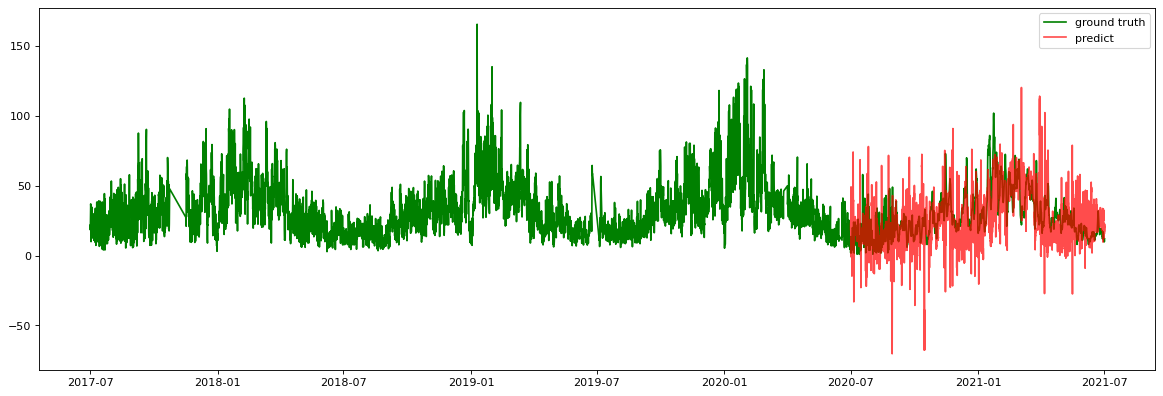

In [31]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [41]:
test_pred_sav['SARA'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_SARA.csv')

#### Surat

In [18]:
Result['SURAT'] = model['SURAT'].predict_step(train_data['SURAT'][['PM25']],
                                    test_data['SURAT'][['PM25']], 
                                    val_X_exog=train_data['SURAT'][exog_columns],
                                    y_exog=test_data['SURAT'][exog_columns], 
                                    model_exog=model_exog['SURAT'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998875,
                                    step=12, learn=True)

train_pred_sav['SURAT'], test_pred_sav['SURAT'], Error_save['SURAT'] = Result['SURAT']

100%|██████████| 4019/4019 [09:38<00:00,  6.95it/s]


In [21]:
with open('model_save/model_surat.model',"wb") as f:
    pickle.dump(model['SURAT'], f)

In [32]:
predict = test_pred_sav['SURAT'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['SURAT'],test_pred_sav['SURAT']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

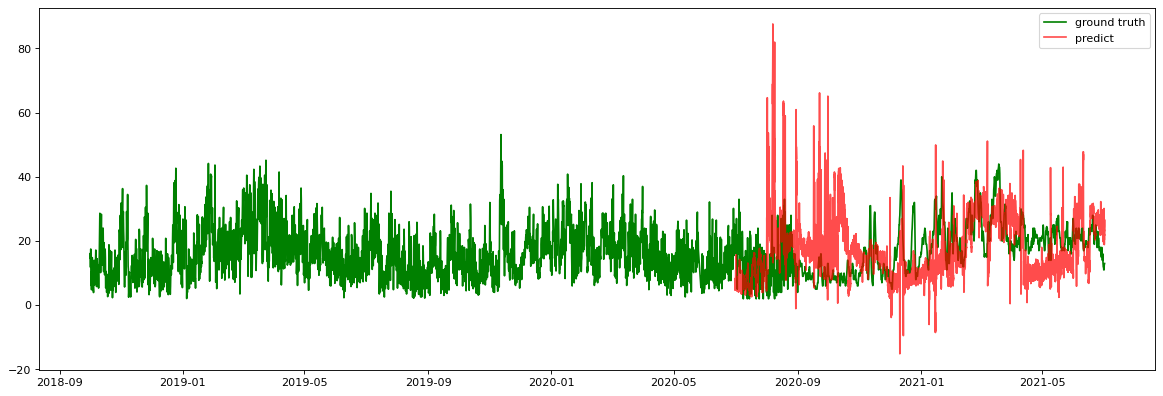

In [33]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [24]:
test_pred_sav['SURAT'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_SURAT.csv')